need to add year variability and add some variability around who is available (i.e. drafts don't perfectly follow ADP, some people slip and some positions are over and under targeted in certain drafts, move the ADP cutoff up and down randomly)

In [1]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

# uncomment when SB3 & wandb are working together again
import wandb
from wandb.integration.sb3 import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grantbell. Use `wandb login --relogin` to force relogin


True

In [2]:
position_map = {0: 'QB', 1: 'RB', 2: 'WR', 3: 'TE'}

class FantasyFootballEnv(gym.Env):
    def __init__(self, teams=12, rounds=7, year=None, first_round_pick=None, data_first_year=2018, data_last_year=2022
                , apply_penalty=False, penalty_amt=-10, adp_variability=True):
        super(FantasyFootballEnv, self).__init__()
        
        # Action space: 0: QB, 1: RB, 2: WR, 3: TE
        self.action_space = spaces.Discrete(4)
        
        self.observation_space = spaces.Box(low=0, high=rounds, shape=(5,), dtype=np.int32)
        
        self.apply_penalty = apply_penalty
        self.penalty_amt = penalty_amt
        self.adp_variability = adp_variability
        
        self.flex_count = 0
        
        # Other initializations
        self.current_round = 1
        self.roster = {'QB': [], 'RB': [], 'WR': [], 'TE': []}
        self.position_counts = {
            'QB': 1,
            'RB': 2,
            'WR': 2,
            'TE': 1,
            'FLEX': 1
        }
        self.flex_positions = ['RB', 'WR', 'TE']
        self.drafted_players = []
        
        self.data_first_year = data_first_year
        self.data_last_year = data_last_year
        self.teams = teams
        self.rounds = rounds
        if year is not None:
            self.year = year
        else:
            self.year = random.randint(2018, 2022)
        if first_round_pick is not None:
            self.first_round_pick = first_round_pick
        else:
            self.first_round_pick = random.randint(1, teams)  
        self.pick = self.first_round_pick
        self.adp_adj = self.calc_adp_adj()
            
        self.player_df = self.create_player_df()
        
        # print(f'Year: {self.year}, First Round Pick: {self.first_round_pick}, Teams: {self.teams}, Rounds: {self.rounds}')
        
    def reset(self, seed=None, year=None, first_round_pick=None):
        
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        
        if year is not None:
            self.year = year
        else:
            self.year = random.randint(2018, 2022)
        if first_round_pick is not None:
            self.first_round_pick = first_round_pick
        else:
            self.first_round_pick = random.randint(1, self.teams)
        self.pick = self.first_round_pick
        self.adp_adj = self.calc_adp_adj()
            
        self.flex_count = 0

        self.current_round = 1
        self.roster = {'QB': [], 'RB': [], 'WR': [], 'TE': []}
        self.drafted_players = []
        
        # Create the initial observation with the current round and counts for each position
        observation = [self.current_round, len(self.roster['QB']), len(self.roster['RB']), len(self.roster['WR']), len(self.roster['TE'])]
                
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        info = {}
        
        # print(f'Year: {self.year}, First Round Pick: {self.first_round_pick}, Teams: {self.teams}, Rounds: {self.rounds}')

                
        return observation, info
    
    def step(self, action):
        
        penalty = False
        done = False
        reward = 0
        
        selected_position = position_map[action]
        
        selected_player, selected_player_points = self.draft_player(selected_position)
        self.roster[selected_position].append(selected_player)
        
        pos_max_exceeded = len(self.roster[selected_position]) > self.position_counts[selected_position]
        flex_pos_selected = selected_position in self.flex_positions
        if pos_max_exceeded & flex_pos_selected:
            self.flex_count += 1
            
        if self.apply_penalty:
            flex_max_exceeded = self.flex_count > self.position_counts['FLEX']
            if (pos_max_exceeded & flex_pos_selected & flex_max_exceeded) | (pos_max_exceeded & ~flex_pos_selected): penalty = True
            if penalty: reward += self.penalty_amt
        
        observation = [self.current_round, len(self.roster['QB']), len(self.roster['RB']), len(self.roster['WR']), len(self.roster['TE'])]
        
        if self.current_round >= self.rounds:
            done = True
            total_points = self.calculate_total_points()
            reward += total_points
        
        info = {}
        info.update({
            'round': self.current_round,
            'pick': self.pick,
            'adp_adj': self.adp_adj,
            'selected_position': selected_position,
            'selected_player': selected_player,
            'selected_player_points': selected_player_points,
            'reward': reward,
            
        })
        
        self.current_round += 1
        self.pick = self.snake_draft_pick()
        self.adp_adj = self.calc_adp_adj()
                
        # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
        return observation, reward, done, False, info
    
    def create_player_df(self):

        player_adp_df = pd.read_csv(f'adp_{self.data_first_year}_{self.data_last_year}.csv')
        player_adp_df = player_adp_df[player_adp_df['Player'].notna()]
        player_adp_df = player_adp_df[player_adp_df['Year'] == self.year]
        player_adp_df['Player'] = player_adp_df['Player'].apply(lambda x: ' '.join(str(x).split()[:2]))
        
        player_performance_df = pd.read_csv(f'player_performance_{self.data_first_year}_{self.data_last_year}.csv')
        player_performance_df = player_performance_df[player_performance_df['Player'].notna()]
        player_performance_df = player_performance_df[player_performance_df['year'] == self.year]
        player_performance_df['Player'] = player_performance_df['Player'].apply(lambda x: ' '.join(str(x).split()[:2]))
        
        player_df = pd.merge(player_adp_df, player_performance_df, on='Player', how='inner')
        player_df['Position'] = player_df['Position'].apply(lambda x: x[:2])        
        player_df['Position'] = player_df['Position'].str[:2]        
        player_df= player_df[['Player', 'Position', 'Rank_x', 'AVG', 'FPTS']]
        
        return player_df
        
    def snake_draft_pick(self):
        if self.current_round % 2 == 1:
            pick = (self.current_round - 1) * self.teams + self.first_round_pick
        else:
            pick = (self.current_round - 1) * self.teams + (self.teams - self.first_round_pick + 1)
        return pick

    
    def calc_adp_adj(self):
        if self.adp_variability:
            if self.current_round == 1:
                adp_adj = random.randint(int(-(self.first_round_pick - 1)/2), int((self.first_round_pick - 1)/2))
            elif self.current_round == 2:
                adp_adj = random.randint(int(-self.teams/2), int(self.teams/2))
            else:
                adp_adj = random.randint(-self.teams, self.teams)
        else:
            adp_adj = 0
        return adp_adj
    
    
    def draft_player(self, selected_position):
                
        available_players = self.player_df[(self.player_df['Position'] == selected_position) & (self.player_df['Rank_x'] >= (self.pick + self.adp_adj)) & (~self.player_df['Player'].isin(self.drafted_players))]  # Filter out players who have already been drafted
        
        selected_player_df = available_players.nsmallest(1, 'AVG')
        selected_player = selected_player_df['Player'].iloc[0]
        selected_player_points = selected_player_df['FPTS'].iloc[0]
        
        self.drafted_players.append(selected_player)
        
        return selected_player, selected_player_points
    
    def custom_policy(self):
        
        eligible_pos = []
        for pos in self.roster.keys():
            if len(self.roster[pos]) < self.position_counts[pos]:
                eligible_pos.append(pos)
        if self.flex_count < self.position_counts['FLEX']:
            eligible_pos += self.flex_positions
        
        available_players = self.player_df[(self.player_df['Position'].isin(eligible_pos)) & (self.player_df['Rank_x'] >= (self.pick + self.adp_adj)) & (~self.player_df['Player'].isin(self.drafted_players))]  # Filter out players who have already been drafted

        selected_player_df = available_players.nsmallest(1, 'AVG')
        selected_player = selected_player_df['Player'].iloc[0]
        selected_player_position = selected_player_df['Position'].iloc[0]
        selected_player_points = selected_player_df['FPTS'].iloc[0]
        
        key_found = None

        for key, value in position_map.items():
            if value == selected_player_position:
                action = key
                break
                    
        return action
        
    
    def calculate_total_points(self):
        
        # note this method assumes you play your best player not the order they are drafted
        
        total_points = 0
        
        for pos in self.roster.keys():
            pos_points_list = [self.player_df[self.player_df['Player'] == player]['FPTS'].iloc[0] for player in self.roster[pos]]
            pos_points_list = sorted(pos_points_list, reverse=True)[:self.position_counts[pos]]
            total_points += sum(pos_points_list)
            
        flex_points_list = []
        for pos in self.flex_positions:
            pos_points_list = [self.player_df[self.player_df['Player'] == player]['FPTS'].iloc[0] for player in self.roster[pos]]
            pos_points_list = sorted(pos_points_list, reverse=True)[self.position_counts[pos]:]
            flex_points_list+=pos_points_list        
        flex_points_list = sorted(flex_points_list, reverse=True)[:self.position_counts[pos]]
        
        total_points+=sum(flex_points_list)
        
        return total_points

In [3]:
def run_training_job(model_type
                    , use_wandb = 'y', wandb_verbose=2
                    , timesteps=1_000_000
                    # , policy='MultiInputPolicy'
                    , policy='MlpPolicy'
                    # should look into mandating that each pick position is considered
                    , n_eval_episodes=12
                    , vec_envs='n', n_envs=4
                    , sb3_model_verbose=0
                    # DQN
                    , dqn_exploration_final_eps=0.025, dqn_exploration_fraction=0.5
                    # PPO
                    # https://colab.research.google.com/drive/1GI0WpThwRHbl-Fu2RHfczq6dci5GBDVE#scrollTo=FMdJRrZ4n7xp
                    , ppo_n_steps = 1024, ppo_batch_size = 64, ppo_n_epochs = 4, ppo_gamma = 0.999, ppo_gae_lambda = 0.98, ppo_ent_coef = 0.01
                    , name_suffix = ''
                    ):
    
    config = {
    "policy_type": policy,
    "total_timesteps": timesteps,
    # "env_id": "NflEnv",
    "env_id": "FantasyFootballEnv",
    }

    # https://stable-baselines3.readthedocs.io/en/master/guide/integrations.html
    if use_wandb == 'y':
        run = wandb.init(
            # project="sb3_nfl_2",
            project="sb3_FantasyFootballEnv",
            config=config,
            sync_tensorboard=True
        )

    # when using multiple environments, the total number of steps taken in counts each step taken in each environment
    # if using 4 environments and 400_000 TIMESTEPS, the agent will take a total of 100_000 steps in each environment.
    if vec_envs == 'y':
        # https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb
        # received 'ValueError: high is out of bounds for int32' without the seed
        # env = make_vec_env(env_id = NflEnv, n_envs=n_envs, seed=1)
        # eval_env = make_vec_env(env_id = NflEnv, n_envs=1, seed=1)
        env = make_vec_env(env_id = FantasyFootballEnv, n_envs=n_envs, seed=1)
        eval_env = make_vec_env(env_id = FantasyFootballEnv, n_envs=1, seed=1)

    elif vec_envs == 'n':
        # env = NflEnv()
        # eval_env = NflEnv()
        env = FantasyFootballEnv()
        eval_env = FantasyFootballEnv()
    
    if use_wandb == 'y':
        if model_type == 'DQN':
            # default values for these parameters are exploration_final_eps=0.05 and exploration_fraction=0.1
            # with the default values, the exploration rate will linearly decrease to 0.05 over the first 10% of the timesteps
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , exploration_final_eps=dqn_exploration_final_eps, exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}"
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose, tensorboard_log=f"runs/{run.id}")
    else:
        if model_type == 'DQN':
            model = DQN(config["policy_type"], env, verbose=sb3_model_verbose, exploration_final_eps=dqn_exploration_final_eps
                        , exploration_fraction = dqn_exploration_fraction)
        elif model_type == 'PPO':
            model = PPO(config["policy_type"], env, verbose=sb3_model_verbose
                        , n_steps = ppo_n_steps, batch_size = ppo_batch_size, n_epochs = ppo_n_epochs, gamma = ppo_gamma
                        , gae_lambda = ppo_gae_lambda, ent_coef = ppo_ent_coef)
        elif model_type == 'A2C':
            model = A2C(config["policy_type"], env, verbose=sb3_model_verbose)

    mean_reward, std_reward = evaluate_policy(model=model, env=eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward before training:{mean_reward:.2f} +/- {std_reward:.2f}")

    if use_wandb == 'y':
        model.learn(
            total_timesteps=config["total_timesteps"],
            callback=WandbCallback(
                model_save_path=f"models/{run.id}",
                verbose=wandb_verbose,
            ),
        )
        run.finish()
    else:
        model.learn(total_timesteps=config["total_timesteps"])

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=n_eval_episodes)
    print(f"mean_reward after training:{mean_reward:.2f} +/- {std_reward:.2f}")

    # parameters_saved = model.get_parameters()
    
    if vec_envs == 'y':
        model.save(f"models/{model_type}_{timesteps}_{n_envs}Envs{name_suffix}")
    else:
        model.save(f"models/{model_type}_{timesteps}_1Envs{name_suffix}")
    
    return model

In [15]:
model_type = 'PPO'
time_steps = 500_000
model = run_training_job(model_type,timesteps=time_steps, use_wandb='n', ppo_gamma=1)

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:787.91 +/- 123.02


c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward after training:1240.09 +/- 132.49


In [16]:
model_type = 'PPO'
time_steps = 1_000_000
model = run_training_job(model_type,timesteps=time_steps, use_wandb='n', ppo_gamma=1)

c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward before training:999.92 +/- 73.98


c:\Users\grant\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward after training:1383.82 +/- 152.80


In [17]:
model_type = 'PPO'
time_steps = 1_000_000
model = run_training_job(model_type, timesteps=time_steps, use_wandb='n', ppo_gamma=1, vec_envs='y')

mean_reward before training:636.47 +/- 73.17
mean_reward after training:1174.56 +/- 184.69


In [27]:
model_type = 'PPO'
time_steps = 2_000_000
model = run_training_job(model_type, timesteps=time_steps, use_wandb='n', ppo_gamma=1, vec_envs='y', n_envs=8)

mean_reward before training:604.10 +/- 61.36
mean_reward after training:1273.30 +/- 148.34


In [5]:
def draft(teams=12, rounds=7, first_round_pick=None, year=None
        , model=None, deterministic=True
        , actions=None
        , custom_policy=False
        , print_round=True, print_score=True
        , adp_variability=False):
    env = FantasyFootballEnv(teams=teams, rounds=rounds, first_round_pick=first_round_pick, year=year, adp_variability=adp_variability)
    state, info = env.reset(first_round_pick=first_round_pick, year=year)
    
    round_nums = []
    picks = []
    positions = []
    players = []
    points = []
    
    for i in range(rounds):
        if model is not None:
            action, _states = model.predict(state, deterministic=deterministic)
            action = int(action)  # If action is an array with a single value that can be directly converted to int
        elif actions is not None:
            action = actions[i]
        
        elif custom_policy:
            action = env.custom_policy()
        
        new_state, reward, done, placeholder, info = env.step(action)
        
        round_num = info['round']
        pick = info['pick']
        position = info['selected_position']
        player = info['selected_player']
        point = info['selected_player_points']
        
        round_nums.append(round_num)
        picks.append(pick)
        positions.append(position)
        players.append(player)
        points.append(point)
        
        if print_round:
            # print(f'Round {info["round"]}, Pick {info["pick"]}, adp_adj {info["adp_adj"]}, Pos {info["selected_position"]}, Player {info["selected_player"]}, points {info["selected_player_points"]}, reward {info["reward"]}')
            print(f'Round {round_num}, Pick {pick}, adp_adj {info["adp_adj"]}, Pos {position}, Player {player}, points {point}, reward {info["reward"]}')
        if print_score:
            if done:
                print(f'year {year}, First Pick {first_round_pick}, total score: {reward}\n')
                
        state = new_state
        
    df = pd.DataFrame({
        'year': year,
        'first_round_pick': first_round_pick,
        'round': round_nums,
        'pick': picks,
        'position': positions,
        'player': players,
        'points': points
    })
    
    # return reward
    return reward, df

def drafts(first_year=2018, last_year=2022, teams=12, actions=None, custom_policy=False, model=None):
    dfs = []
    years =[]
    picks = []
    scores = []
    for year in range(first_year, last_year+1):
        for first_round_pick in range (1, teams+1):
            score, df = draft(first_round_pick=first_round_pick, year=year, teams=teams
                        , actions=actions, custom_policy=custom_policy, model=model
                        , print_round=False, print_score=False)
            
            aggregated_row = df.groupby(['year', 'first_round_pick']).agg({'points': 'sum'}).reset_index()
            aggregated_row['round'] = 'Total'
            columns_to_nan = ['pick', 'position', 'player', 'position_rank']
            for col in columns_to_nan:
                aggregated_row[col] = None
            df = pd.concat([df, aggregated_row], ignore_index=True)
            
            years.append(year)
            picks.append(first_round_pick)
            scores.append(score)
            dfs.append(df)
    avg = np.mean(scores)
    std = np.std(scores)
    print(f'avg: {avg}, std: {std}')
    
    df = pd.concat(dfs, ignore_index=True)
    
    df['position_rank'] = df.groupby(['year', 'first_round_pick', 'position'])['points'].rank(method='first', ascending=False)
    df = df.sort_values(by=['year', 'first_round_pick', 'position', 'position_rank'])
    df.loc[df['position_rank'] > 2, 'position'] = 'FLEX'
    
    return df

In [19]:
year = random.randint(2018, 2022)
first_round_pick = random.randint(1, 12)
print(f'Year: {year}, First Round Pick: {first_round_pick}')

Year: 2019, First Round Pick: 3


In [20]:
print("rb first")
actions = [1, 1, 2, 2, 2, 3, 0]
draft(first_round_pick=first_round_pick, year=year, actions=actions)
df = drafts(actions=actions)
df.to_csv(f'data/drafts/rbFirst.csv', index=False)

rb first
Round 1, Pick 3, adp_adj 0, Pos RB, Player Christian McCaffrey, points 413.2, reward 0
Round 2, Pick 22, adp_adj 0, Pos RB, Player Leonard Fournette, points 221.4, reward 0
Round 3, Pick 27, adp_adj 0, Pos WR, Player Amari Cooper, points 207.0, reward 0
Round 4, Pick 46, adp_adj 0, Pos WR, Player Kenny Golladay, points 215.5, reward 0
Round 5, Pick 51, adp_adj 0, Pos WR, Player Cooper Kupp, points 223.5, reward 0
Round 6, Pick 70, adp_adj 0, Pos TE, Player Jared Cook, points 146.0, reward 0
Round 7, Pick 75, adp_adj 0, Pos QB, Player Drew Brees, points 228.8, reward 1655.4
year 2019, First Pick 3, total score: 1655.4

avg: 1303.655, std: 164.74507825222983


In [21]:
print("custom policy")
draft(first_round_pick=first_round_pick, year=year, custom_policy=True)
df = drafts(custom_policy=True)
df.to_csv(f'data/drafts/custom.csv', index=False)

custom policy
Round 1, Pick 3, adp_adj 0, Pos RB, Player Christian McCaffrey, points 413.2, reward 0
Round 2, Pick 22, adp_adj 0, Pos WR, Player Antonio Brown, points 14.1, reward 0
Round 3, Pick 27, adp_adj 0, Pos RB, Player Damien Williams, points 126.1, reward 0
Round 4, Pick 46, adp_adj 0, Pos WR, Player Kenny Golladay, points 215.5, reward 0
Round 5, Pick 51, adp_adj 0, Pos WR, Player Cooper Kupp, points 223.5, reward 0
Round 6, Pick 70, adp_adj 0, Pos TE, Player Jared Cook, points 146.0, reward 0
Round 7, Pick 75, adp_adj 0, Pos QB, Player Drew Brees, points 228.8, reward 1367.1999999999998
year 2019, First Pick 3, total score: 1367.1999999999998

avg: 1292.71, std: 134.1658559395795


In [25]:
time_steps = 500_000
model_type = 'PPO'
envs = 1
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=1, year=2022, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 500000 time_steps
Round 1, Pick 1, adp_adj 0, Pos TE, Player Travis Kelce, points 261.3, reward 0
Round 2, Pick 24, adp_adj 0, Pos RB, Player Ezekiel Elliott, points 177.3, reward 0
Round 3, Pick 25, adp_adj 0, Pos QB, Player Patrick Mahomes, points 428.9, reward 0
Round 4, Pick 48, adp_adj 0, Pos WR, Player Diontae Johnson, points 137.7, reward 0
Round 5, Pick 49, adp_adj 0, Pos RB, Player Josh Jacobs, points 301.8, reward 0
Round 6, Pick 72, adp_adj 0, Pos WR, Player Adam Thielen, points 145.0, reward 0
Round 7, Pick 73, adp_adj 0, Pos RB, Player Damien Harris, points 82.4, reward 1534.4
year 2022, First Pick 1, total score: 1534.4

avg: 1281.335, std: 195.31218670374872


In [23]:
time_steps = 1_000_000
model_type = 'PPO'
envs = 1
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=1, year=2022, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 1000000 time_steps
Round 1, Pick 1, adp_adj 0, Pos TE, Player Travis Kelce, points 261.3, reward 0
Round 2, Pick 24, adp_adj 0, Pos RB, Player Ezekiel Elliott, points 177.3, reward 0
Round 3, Pick 25, adp_adj 0, Pos QB, Player Patrick Mahomes, points 428.9, reward 0
Round 4, Pick 48, adp_adj 0, Pos WR, Player Diontae Johnson, points 137.7, reward 0
Round 5, Pick 49, adp_adj 0, Pos WR, Player Jaylen Waddle, points 221.7, reward 0
Round 6, Pick 72, adp_adj 0, Pos RB, Player Chase Edmonds, points 66.2, reward 0
Round 7, Pick 73, adp_adj 0, Pos WR, Player Adam Thielen, points 145.0, reward 1438.1
year 2022, First Pick 1, total score: 1438.1

avg: 1278.7666666666667, std: 159.2797273841073


In [24]:
time_steps = 1_000_000
model_type = 'PPO'
envs = 4
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=6, year=2018, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 1000000 time_steps
Round 1, Pick 6, adp_adj 0, Pos TE, Player Rob Gronkowski, points 107.7, reward 0
Round 2, Pick 19, adp_adj 0, Pos RB, Player Jordan Howard, points 170.0, reward 0
Round 3, Pick 30, adp_adj 0, Pos QB, Player Aaron Rodgers, points 312.5, reward 0
Round 4, Pick 43, adp_adj 0, Pos WR, Player Josh Gordon, points 118.2, reward 0
Round 5, Pick 54, adp_adj 0, Pos WR, Player Chris Hogan, points 88.7, reward 0
Round 6, Pick 67, adp_adj 0, Pos RB, Player Sony Michel, points 135.6, reward 0
Round 7, Pick 78, adp_adj 0, Pos RB, Player Ronald Jones, points 17.2, reward 949.9000000000001
year 2018, First Pick 6, total score: 949.9000000000001

avg: 1307.3366666666666, std: 194.34943698286224


In [28]:
time_steps = 2_000_000
model_type = 'PPO'
envs = 8
print(f'agent {time_steps} time_steps')
model = PPO.load(f'models/{model_type}_{time_steps}_{envs}Envs')
draft(first_round_pick=6, year=2018, model=model)
df = drafts(model=model)
df.to_csv(f'data/drafts/{model_type}_{time_steps}_{envs}Envs.csv', index=False)

agent 2000000 time_steps
Round 1, Pick 6, adp_adj 0, Pos WR, Player DeAndre Hopkins, points 276.0, reward 0
Round 2, Pick 19, adp_adj 0, Pos TE, Player Rob Gronkowski, points 107.7, reward 0
Round 3, Pick 30, adp_adj 0, Pos QB, Player Aaron Rodgers, points 312.5, reward 0
Round 4, Pick 43, adp_adj 0, Pos WR, Player Josh Gordon, points 118.2, reward 0
Round 5, Pick 54, adp_adj 0, Pos WR, Player Chris Hogan, points 88.7, reward 0
Round 6, Pick 67, adp_adj 0, Pos RB, Player Sony Michel, points 135.6, reward 0
Round 7, Pick 78, adp_adj 0, Pos RB, Player Ronald Jones, points 17.2, reward 1055.9
year 2018, First Pick 6, total score: 1055.9

avg: 1288.4699999999998, std: 162.4083467682619


In [26]:
# 2018 to 2022
year = 2018
# 1 to 12
first_round_pick = 6

# columns=['year', 'first_round_pick', 'position', 'position_rank', 'round', 'player', 'points']
columns=['year', 'first_round_pick', 'position', 'position_rank', 'round', 'pick', 'player', 'points']
df_left = pd.read_csv('data/drafts/PPO_1000000_4Envs.csv')
df_left= pd.DataFrame(df_left, columns=columns)
df_right = pd.read_csv('data/drafts/custom.csv')
df_right= pd.DataFrame(df_right, columns=columns)
df = df_left.merge(df_right, how='inner', on=['year', 'first_round_pick', 'position', 'position_rank'], suffixes=('_a', '_b'))
df = df[(df['year'] == year) & (df['first_round_pick'] == first_round_pick)]
df['difference'] = df['points_a'] - df['points_b']
df

,year,first_round_pick,position,position_rank,round_a,pick_a,player_a,points_a,round_b,pick_b,player_b,points_b,difference
39,2018,6,QB,1.0,3,30.0,Aaron Rodgers,312.5,3,30.0,Aaron Rodgers,312.5,0.0
40,2018,6,RB,1.0,2,19.0,Jordan Howard,170.0,1,6.0,Alvin Kamara,313.7,-143.7
41,2018,6,RB,2.0,6,67.0,Sony Michel,135.6,4,43.0,Lamar Miller,160.1,-24.5
42,2018,6,FLEX,3.0,7,78.0,Ronald Jones,17.2,5,54.0,Marshawn Lynch,71.5,-54.3
43,2018,6,TE,1.0,1,6.0,Rob Gronkowski,107.7,7,78.0,Delanie Walker,7.2,100.5
44,2018,6,WR,1.0,4,43.0,Josh Gordon,118.2,2,19.0,Davante Adams,274.1,-155.9
45,2018,6,WR,2.0,5,54.0,Chris Hogan,88.7,6,67.0,Marquise Goodwin,75.9,12.8
46,2018,6,NaN,NaN,Total,NaN,NaN,949.9,Total,NaN,NaN,1215.0,-265.1


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided files
custom_df = pd.read_csv('data/drafts/custom.csv')
ppo_df = pd.read_csv('data/drafts/PPO_1000000_4Envs.csv')
# Filter data for rows where round is 'Total'
custom_total = custom_df[custom_df['round'] == 'Total']
ppo_total = ppo_df[ppo_df['round'] == 'Total']

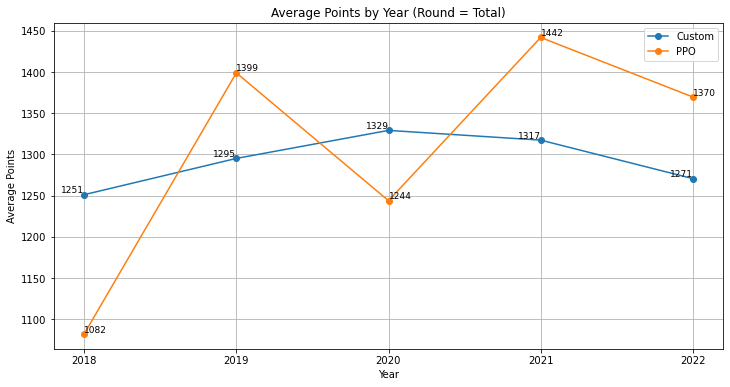

In [18]:
# Group by year and calculate average points
custom_avg = custom_total.groupby('year')['points'].mean()
ppo_avg = ppo_total.groupby('year')['points'].mean()

# Plot the average points by year with labeled points
plt.figure(figsize=(12, 6))

# Plot and label for custom data
custom_avg.plot(label='Custom', marker='o')
for x, y in custom_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='right', va='bottom', fontsize=9)

# Plot and label for PPO data
ppo_avg.plot(label='PPO', marker='o')
for x, y in ppo_avg.items():
    plt.text(x, y, f'{y:.0f}', ha='left', va='bottom', fontsize=9)


plt.title('Average Points by Year (Round = Total)')
plt.xlabel('Year')
plt.ylabel('Average Points')
plt.xticks(ticks=custom_avg.index)  # Setting x-ticks to display only whole years
plt.legend()
plt.grid(True)
plt.show()


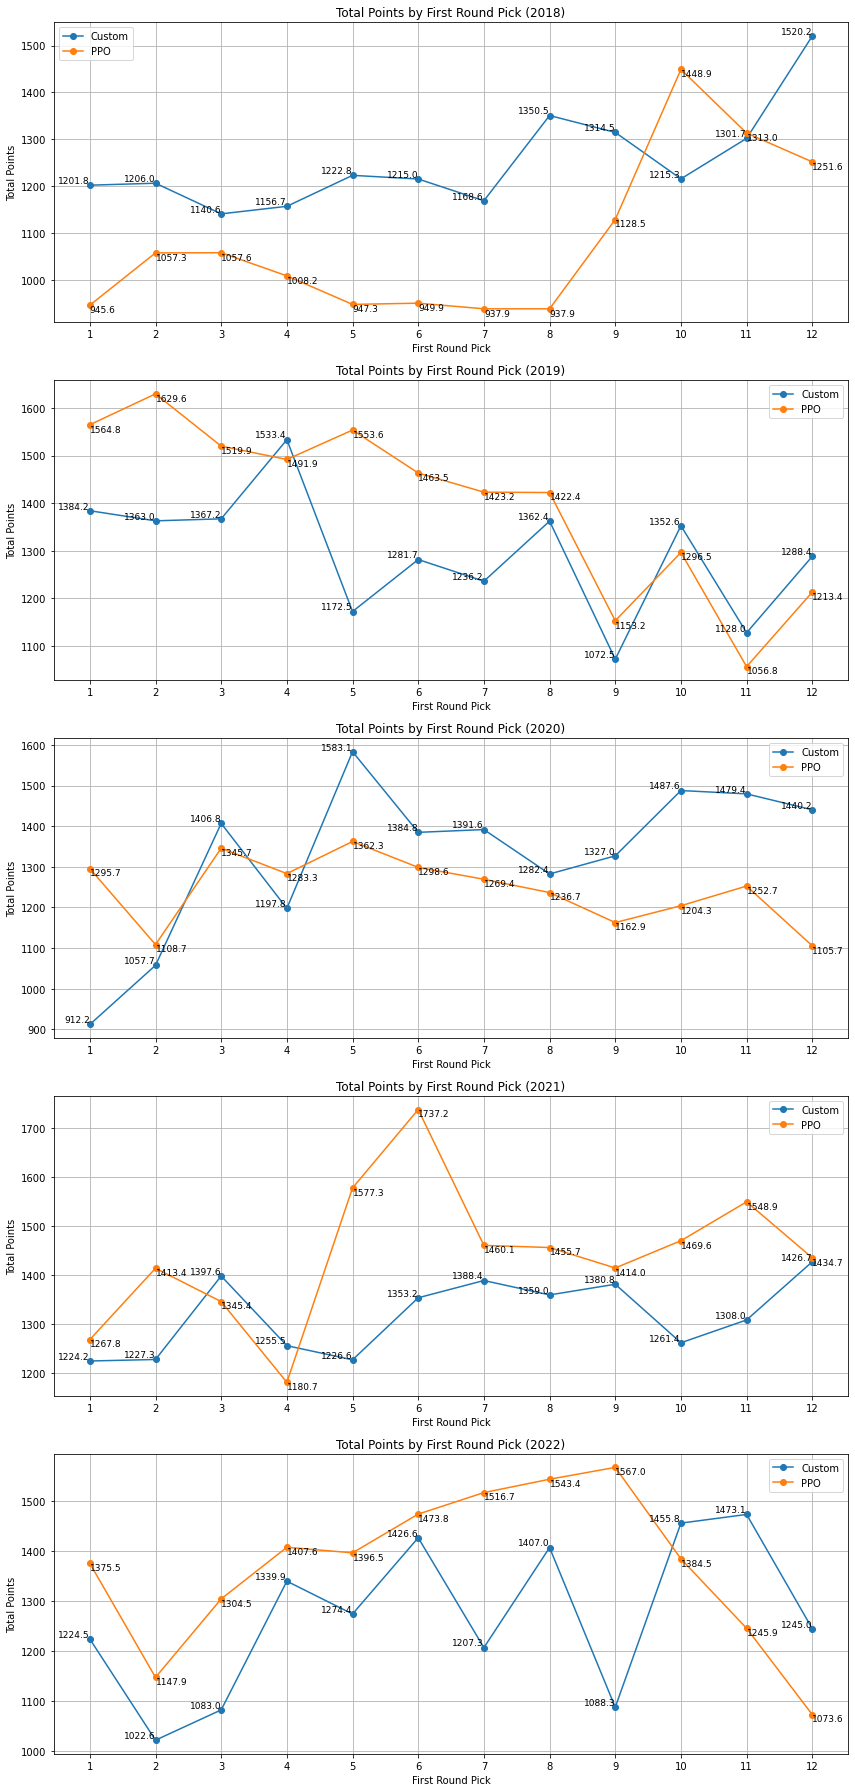

In [20]:
# Grouping data by year and first round pick and summing up the points
custom_grouped = custom_total.groupby(['year', 'first_round_pick'])['points'].sum().unstack()
ppo_grouped = ppo_total.groupby(['year', 'first_round_pick'])['points'].sum().unstack()

# Plotting combined data for each year
fig, axes = plt.subplots(len(years), 1, figsize=(12, 5 * len(years)))

for i, year in enumerate(years):
    ax = axes[i]
    custom_grouped.loc[year].plot(ax=ax, label='Custom', marker='o')
    ppo_grouped.loc[year].plot(ax=ax, label='PPO', marker='o')
    
    # Adding labels for each point
    for x, y in custom_grouped.loc[year].items():
        ax.text(x, y, f'{y:.1f}', ha='right', va='bottom', fontsize=9)
    for x, y in ppo_grouped.loc[year].items():
        ax.text(x, y, f'{y:.1f}', ha='left', va='top', fontsize=9)
        
    # Set x-axis labels to display every pick number
    ax.set_xticks(custom_grouped.columns)
    
    ax.set_title(f'Total Points by First Round Pick ({year})')
    ax.set_xlabel('First Round Pick')
    ax.set_ylabel('Total Points')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()